In [1]:
# Clone into a writable directory
!git clone https://github.com/AntonioTepsich/ckan.git /kaggle/working/Convolutional-KANs
%cd /kaggle/working/Convolutional-KANs

Cloning into '/kaggle/working/Convolutional-KANs'...
remote: Enumerating objects: 2379, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 2379 (delta 266), reused 311 (delta 196), pack-reused 1970 (from 1)
Receiving objects: 100% (2379/2379), 45.65 MiB | 36.32 MiB/s, done.
Resolving deltas: 100% (1286/1286), done.
/kaggle/working/Convolutional-KANs


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan_convolutional.KANConv import KAN_Convolutional_Layer
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
class KANC_MLP(nn.Module):
    def __init__(self, grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            in_channels=1,
            out_channels=5,
            kernel_size=(3,3),
            grid_size=grid_size
        )
        self.conv2 = KAN_Convolutional_Layer(
            in_channels=5,
            out_channels=5,
            kernel_size=(3,3),
            grid_size=grid_size
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(125, 10)
        self.name = f"KANC MLP (Small) (gs = {grid_size})"

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        # Uncomment next line if you get dimension errors
        # print(x.shape)
        x = self.linear1(x)
        x = F.log_softmax(x, dim=1)
        return x

In [4]:
# Enhanced transforms with augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset into Kaggle's writable directory
full_train_dataset = MNIST(root='/kaggle/working/data', train=True, download=True, transform=train_transform)
test_dataset = MNIST(root='/kaggle/working/data', train=False, download=True, transform=test_transform)

# Split into train and validation (80-20 split)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting /kaggle/working/data/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 459kB/s]


Extracting /kaggle/working/data/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]


Extracting /kaggle/working/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.83MB/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KANC_MLP(grid_size=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  # Removed verbose=True

# Verify GPU availability
print(f"Using device: {device}")

Using device: cuda


In [6]:
epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Step the scheduler
    scheduler.step(avg_val_loss)

Epoch [1/10]
Train Loss: 0.6639, Val Loss: 0.3151, Val Accuracy: 90.55%
Epoch [2/10]
Train Loss: 0.2891, Val Loss: 0.2536, Val Accuracy: 92.14%
Epoch [3/10]
Train Loss: 0.2557, Val Loss: 0.2371, Val Accuracy: 92.82%
Epoch [4/10]
Train Loss: 0.2357, Val Loss: 0.2377, Val Accuracy: 92.40%
Epoch [5/10]
Train Loss: 0.2209, Val Loss: 0.2083, Val Accuracy: 93.46%
Epoch [6/10]
Train Loss: 0.2142, Val Loss: 0.2105, Val Accuracy: 93.51%
Epoch [7/10]
Train Loss: 0.2104, Val Loss: 0.2038, Val Accuracy: 93.60%
Epoch [8/10]
Train Loss: 0.2076, Val Loss: 0.1927, Val Accuracy: 94.03%
Epoch [9/10]
Train Loss: 0.1999, Val Loss: 0.1951, Val Accuracy: 93.80%
Epoch [10/10]
Train Loss: 0.1972, Val Loss: 0.2002, Val Accuracy: 93.79%



Test set:
Accuracy: 97.59%
Precision: 0.98
Recall: 0.98
F1 Score: 0.98


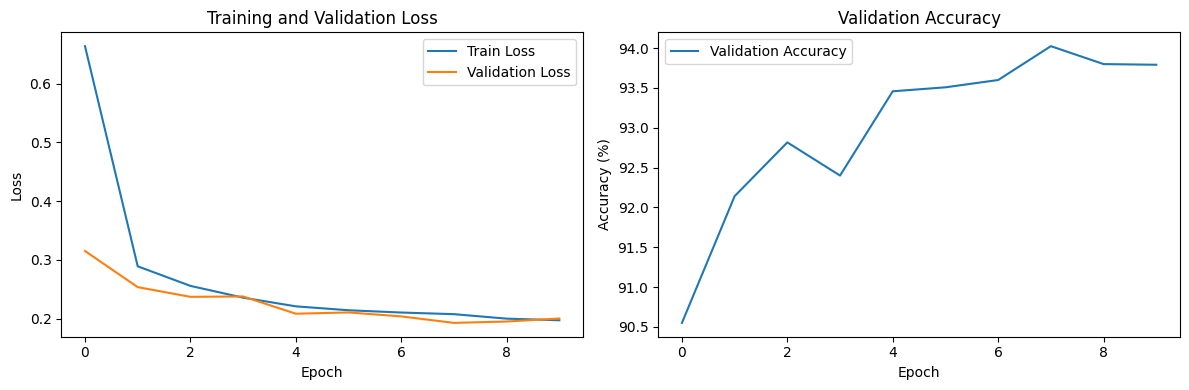

In [7]:
# Test evaluation
model.eval()
test_loss = 0
correct = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (labels == predicted).sum().item()
        all_targets.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / len(test_loader.dataset)
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')

print('\nTest set:')
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Learning curves visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()